# Facial AU Results Analysis 
- Date: 2024-12-16
- Environment: ASD_Face_env



### Data Description

- AU distribution: https://www.cs.cmu.edu/~face/facs.htm
- AU01_c: AU presence 0 invisible 1 visible
    - 18 AUs can be detected for presence: AU01_r, AU02_r, AU04_r, AU05_r, AU06_r, AU07_r, AU09_r, AU10_r, AU12_r, AU14_r, AU15_r, AU17_r, AU20_r, AU23_r, AU25_r, AU26_r, AU45_r
- AU01_r: AU intensity 0 non-existent 1 minimum intensity exists 5 maximum intensity exists continuous values
    - 17 AUs can be detected for intensity: AU01_r, AU02_r, AU04_r, AU05_r, AU06_r, AU07_r, AU09_r, AU10_r, AU12_r, AU14_r, AU15_r, AU17_r, AU20_r, AU23_r, AU25_r, AU26_r, AU45_r
    - Note: _c and _r are trained on different models, prediction values may be inconsistent, i.e., AU01_c=1 AU01_r=0 may exist
- gaze_0_x, gaze_0_y, gaze_0_z: Eye gaze direction vector in world coordinates for eye 0, the leftmost eye in the image (regarded as a ray emitted from the left eye in the image towards the eye gaze direction)
- gaze_1_x, gaze_1_y, gaze_1_z: Eye gaze direction vector in world coordinates for eye 1, the rightmost eye in the image (regarded as a ray emitted from the right eye in the image towards the eye gaze direction)
- gaze_angle_x, gaze_angle_y: When a person looks from left to right, this will cause changes in gaze_angle_x (from positive to negative); if a person looks from top to bottom, it will cause changes in gaze_angle_y (from negative to positive). If a person looks straight ahead, both angles will be close to 0 (within measurement error range).
- eye_lmk_x_0, eye_lmk_x_1,... eye_lmk_x55, eye_lmk_y_1,... eye_lmk_y_55: 2D eye region landmark positions (in pixels)
    - 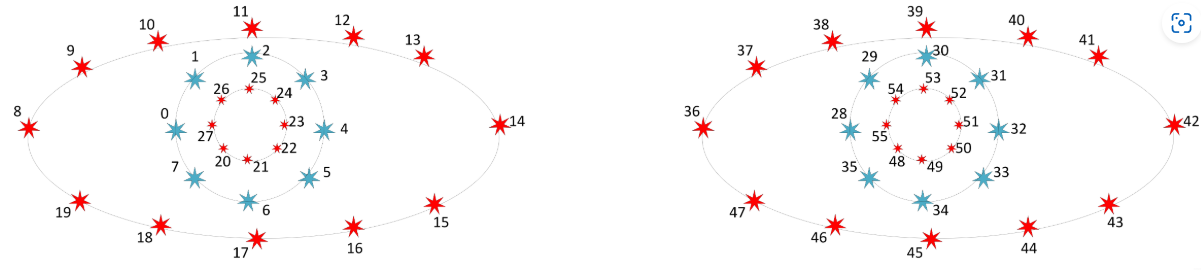
- pose_Tx, pose_Ty, pose_Tz: Head position relative to camera in millimeters (positive Z is farther from camera)
- pose_Rx, pose_Ry, pose_Rz: Radian rotation around X, Y, Z axes, with left-hand convention as positive. Can be regarded as pitch (Rx), yaw (Ry) and roll (Rz). Rotation in world coordinates with camera as origin.


### Analysis Code

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
import os
plt.rcParams['font.sans-serif'] = ['SimHei']  # Used to display Chinese labels normally
plt.rcParams['axes.unicode_minus'] = False     # Used to display negative signs normally

#### AU Intensity Changes Across Emotions

In [ ]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
import os

def get_interference_frames(subject, events_dir="result/Events"):
    """Get positions of interference frames"""
    from lib.EventTracking import Events
    
    # Read event file
    event_file = os.path.join(events_dir, f"{subject}.json")
    if not os.path.exists(event_file):
        print(f"警告: 未找到{subject}的事件文件")
        return []
        
    # Load event data
    events = Events(event_file)
    
    # Filter interference events (adjust according to actual label names)
    interference_events = events.filter_by_label(stay_labels=['口罩'])

    # Get list of interference frame positions [[start_frame, end_frame], ...]
    if not interference_events.events:  # If no interference events
        return []
    
    # Get list of interference frame positions [[start_frame, end_frame], ...]
    interference_frames = interference_events.get_frame_list(sr=50)  # Assume video frame rate is 30fps
    return interference_frames

def replace_outliers(group_data, k=1.5):
    """Identify and handle outliers using IQR method
    k=1.5 is commonly used, k=3.0 is the standard for extreme values"""
    Q1 = group_data.quantile(0.25)
    Q3 = group_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    outlier_mask = (group_data < lower_bound) | (group_data > upper_bound)
    cleaned_data = group_data.copy()
    cleaned_data[outlier_mask] = group_data.median()  # Replace with median
    return cleaned_data

def calculate_au_statistics(emotion):
    """
    Calculate AU intensity statistics for specified emotion and save results
    """
    # Read data
    au_dir = "result/AUs"
    emotion_dir = "result/Emotions_smooth2"
    demo_df = pd.read_csv("result/demographics.csv")

    # Store AU data for all subjects
    all_au_data = []
    total_subjects = len(demo_df)
    processed_subjects = {'TD': 0, 'ASD': 0}

    print(f"\n开始提取{emotion}情绪下的AU强度数据...")

    # Iterate through each subject
    for i, (_, row) in enumerate(demo_df.iterrows(), 1):
        subject = row['姓名']
        group = row['组别']

        print(f"\r处理进度：{i}/{total_subjects} ({i/total_subjects*100:.1f}%) - 当前处理：{subject}", 
              end='', flush=True)

        try:
            # Read emotion data
            emotion_file = os.path.join(emotion_dir, f"{subject}.csv")
            with open(emotion_file, 'r') as f:
                next(f)
                next(f)
                emotion_df = pd.read_csv(f)
            
            # Read AU data
            au_file = os.path.join(au_dir, subject, "M1_2.csv")
            au_df = pd.read_csv(au_file)
            au_df.columns = au_df.columns.str.strip()

            # Check if frame counts match
            if not len(emotion_df) == len(au_df):
                print(f"\n警告: {subject} 的帧数不匹配!")
                continue

            # Get interference frame positions
            interference_frames = get_interference_frames(subject)
            
            # Create interference frame mask (True means non-interference frame)
            interference_mask = np.ones(len(au_df), dtype=bool)
            if interference_frames:  # Only update mask if there are interference frames
                for start_frame, end_frame in interference_frames:
                    interference_mask[start_frame:end_frame+1] = False
            
            # Get AU intensity columns and presence columns
            au_intensity_cols = [col for col in au_df.columns if '_r' in col and 'AU' in col]
            au_presence_cols = [col.replace('_r', '_c') for col in au_intensity_cols]
            
            # Get frames for target emotion
            emotion_mask = emotion_df['SmoothedEmotion'] == emotion
            valid_mask = (emotion_mask) & (au_df['success'] == 1) & (interference_mask)
            
            if valid_mask.sum() == 0:
                continue

            # Calculate mean intensity for each AU (only consider existing AUs)
            au_means = {}
            for intensity_col, presence_col in zip(au_intensity_cols, au_presence_cols):
                # Get frames where AU exists and emotion is valid
                au_valid_mask = valid_mask & (au_df[presence_col] == 1)
                # au_valid_mask = valid_mask
                if au_valid_mask.sum() > 0:
                    au_means[intensity_col] = au_df.loc[au_valid_mask, intensity_col].mean()
                else:
                    au_means[intensity_col] = np.nan  # Use null values to indicate invalid AU
            
            # Add subject information
            au_means['姓名'] = subject
            au_means['group'] = group
            
            all_au_data.append(au_means)
            processed_subjects['TD' if group == 0 else 'ASD'] += 1

        except Exception as e:
            print(f"\n警告: 处理{subject}时出错 - {str(e)}")
            continue

    if not all_au_data:
        print(f"\n错误: 没有找到{emotion}情绪的有效数据")
        return None

    # Convert to DataFrame
    results_df = pd.DataFrame(all_au_data)
    
    # Get all AU columns
    au_cols = [col for col in results_df.columns if '_r' in col]
    
    # Replace outliers (exclude null values)
    for au_col in au_cols:
        # Replace outliers by group
        td_mask = results_df['group'] == 0
        asd_mask = results_df['group'] == 1
        
        # Perform outlier processing on non-null values
        td_data = results_df.loc[td_mask, au_col]
        asd_data = results_df.loc[asd_mask, au_col]
        
        # Get indices of non-null values
        td_valid_idx = td_data[td_data.notna()].index
        asd_valid_idx = asd_data[asd_data.notna()].index
        
        # Only perform outlier processing on non-null values, maintaining original indices
        if len(td_valid_idx) > 0:
            results_df.loc[td_valid_idx, au_col] = replace_outliers(td_data[td_valid_idx])
        if len(asd_valid_idx) > 0:
            results_df.loc[asd_valid_idx, au_col] = replace_outliers(asd_data[asd_valid_idx])
    
    # Fill null values
    results_df = results_df.fillna(0)

    # Create output directory
    output_dir = "result/AU_Analysis_0220"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save processed data
    results_df.to_csv(os.path.join(output_dir, f"au_intensities_{emotion}.csv"), index=False, encoding='utf-8-sig')
    
    # Calculate statistics
    stats_results = []
    p_values = []
    
    # Collect all p-values for FDR correction
    for au_col in au_cols:
        td_data = results_df[results_df['group'] == 0][au_col]
        asd_data = results_df[results_df['group'] == 1][au_col]
        _, p_value = stats.mannwhitneyu(td_data, asd_data, alternative='two-sided')
        p_values.append(p_value)
    
    # Perform FDR correction
    _, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')
    
    # Calculate statistics for each AU
    for au_col, p_value, p_adj in zip(au_cols, p_values, p_corrected):
        td_data = results_df[results_df['group'] == 0][au_col]
        asd_data = results_df[results_df['group'] == 1][au_col]
        
        # Add significance markers
        sig_fdr = ''
        if p_adj < 0.001:
            sig_fdr = '***'
        elif p_adj < 0.01:
            sig_fdr = '**'
        elif p_adj < 0.05:
            sig_fdr = '*'

        stats_results.append({
            'AU': au_col.replace('_r', ''),
            'TD_N': len(td_data),
            'ASD_N': len(asd_data),
            'TD_Mean': td_data.mean(),
            'TD_SD': td_data.std(),
            'ASD_Mean': asd_data.mean(),
            'ASD_SD': asd_data.std(),
            'p_value': p_value,
            'p_adjusted_fdr': p_adj,
            'Sig_FDR': sig_fdr,
                    })
    
    # Save statistical results
    stats_df = pd.DataFrame(stats_results)
    stats_df.to_csv(os.path.join(output_dir, f"au_stats_{emotion}.csv"), index=False, encoding='utf-8-sig')
    
    print(f"\n数据处理完成!")
    print(f"TD组: {processed_subjects['TD']}人")
    print(f"ASD组: {processed_subjects['ASD']}人")
    print(f"处理后的数据已保存至: {output_dir}/au_intensities_{emotion}.csv")
    print(f"统计结果已保存至: {output_dir}/au_stats_{emotion}.csv")
    
    return results_df, stats_df

"""Main function: analyze all emotions"""
emotions = ['neutral', 'happy', 'sad', 'surprise', 'anger']

# emotions = []
# Calculate emotion intensity and analyze group differences
for emotion in emotions:
    print(f"\n{'='*50}")
    print(f"开始计算 {emotion} 情绪的统计量")
    print(f"{'='*50}")
    calculate_au_statistics(emotion)



开始计算 happy 情绪的统计量

开始提取happy情绪下的AU强度数据...
处理进度：184/184 (100.0%) - 当前处理：江奕菲阿斯伯格）
数据处理完成!
TD组: 76人
ASD组: 95人
处理后的数据已保存至: result/AU_Analysis_0220/au_intensities_happy.csv
统计结果已保存至: result/AU_Analysis_0220/au_stats_happy.csv

开始计算 sad 情绪的统计量

开始提取sad情绪下的AU强度数据...
处理进度：184/184 (100.0%) - 当前处理：江奕菲阿斯伯格）
数据处理完成!
TD组: 84人
ASD组: 98人
处理后的数据已保存至: result/AU_Analysis_0220/au_intensities_sad.csv
统计结果已保存至: result/AU_Analysis_0220/au_stats_sad.csv

开始计算 surprise 情绪的统计量

开始提取surprise情绪下的AU强度数据...
处理进度：184/184 (100.0%) - 当前处理：江奕菲阿斯伯格）
数据处理完成!
TD组: 83人
ASD组: 99人
处理后的数据已保存至: result/AU_Analysis_0220/au_intensities_surprise.csv
统计结果已保存至: result/AU_Analysis_0220/au_stats_surprise.csv

开始计算 anger 情绪的统计量

开始提取anger情绪下的AU强度数据...
处理进度：184/184 (100.0%) - 当前处理：江奕菲阿斯伯格）
数据处理完成!
TD组: 60人
ASD组: 86人
处理后的数据已保存至: result/AU_Analysis_0220/au_intensities_anger.csv
统计结果已保存至: result/AU_Analysis_0220/au_stats_anger.csv


In [ ]:
# For plotting: scale AU intensity values with a linear function
def scale_au_intensities(emotion):
    """
    Scale AU intensity data:
    - When value < 1, new value = original value * 3
    - When value >= 1, new value = original value + 2
    """
    # Read data
    input_dir = "result/AU_Analysis"
    file_path = os.path.join(input_dir, f"au_intensities_{emotion}.csv")
    
    # Read original data
    df = pd.read_csv(file_path)
    
    # Get all AU columns
    au_cols = [col for col in df.columns if '_r' in col]
    
    # Scale each AU column
    for col in au_cols:
        # Create masks
        small_mask = df[col] < 1
        large_mask = df[col] >= 1
        
        # Apply scaling rules
        df.loc[small_mask, col] = df.loc[small_mask, col] * 4
        df.loc[large_mask, col] = df.loc[large_mask, col] + 3
    
    # Save scaled data
    output_file = os.path.join(input_dir, f"au_intensities_{emotion}_scaled.csv")
    df.to_csv(output_file, index=False, encoding='utf-8-sig')
    
    print(f"放缩后的数据已保存至: {output_file}")
    return df

# Process all emotion data
emotions = ['neutral', 'happy', 'sad', 'surprise', 'anger']
for emotion in emotions:
    print(f"\n处理 {emotion} 情绪的数据...")
    scale_au_intensities(emotion)


处理 neutral 情绪的数据...
放缩后的数据已保存至: result/AU_Analysis\au_intensities_neutral_scaled.csv

处理 happy 情绪的数据...
放缩后的数据已保存至: result/AU_Analysis\au_intensities_happy_scaled.csv

处理 sad 情绪的数据...
放缩后的数据已保存至: result/AU_Analysis\au_intensities_sad_scaled.csv

处理 surprise 情绪的数据...
放缩后的数据已保存至: result/AU_Analysis\au_intensities_surprise_scaled.csv

处理 anger 情绪的数据...
放缩后的数据已保存至: result/AU_Analysis\au_intensities_anger_scaled.csv


#### AU Correlations Across Emotions

In [ ]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
import os


In [ ]:
def get_interference_frames(subject, events_dir="result/Events"):
    """Get positions of interference frames"""
    from lib.EventTracking import Events
    
    # Read event file
    event_file = os.path.join(events_dir, f"{subject}.json")
    if not os.path.exists(event_file):
        print(f"警告: 未找到{subject}的事件文件")
        return []
        
    # Load event data
    events = Events(event_file)
    
    # Filter interference events (adjust according to actual label names)
    interference_events = events.filter_by_label(stay_labels=['口罩'])

    # Get list of interference frame positions [[start_frame, end_frame], ...]
    if not interference_events.events:  # If no interference events
        return []
    
    # Get list of interference frame positions [[start_frame, end_frame], ...]
    interference_frames = interference_events.get_frame_list(sr=50)  # Assume video frame rate is 30fps
    return interference_frames

def replace_outliers(group_data, k=1.5):
    """Identify and handle outliers using IQR method
    k=1.5 is commonly used, k=3.0 is the standard for extreme values"""
    Q1 = group_data.quantile(0.25)
    Q3 = group_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    outlier_mask = (group_data < lower_bound) | (group_data > upper_bound)
    cleaned_data = group_data.copy()
    cleaned_data[outlier_mask] = group_data.median()  # Replace with median
    return cleaned_data

In [ ]:
def analyze_au_intensity_correlations(emotion='happy'):
    """Analyze correlations between AU intensities under specific emotions, calculated separately by emotion segments, excluding segments containing interference
    """
    print(f"\n提取{emotion}情绪下AU强度值间相关性特征...")
    
    # Read data
    au_dir = "result/AUs"
    emotion_dir = "result/Emotions_smooth2"
    demo_df = pd.read_csv("result/demographics.csv")
    
    # Store correlation results for all subjects
    all_results = {}
    total_subjects = len(demo_df)
    
    print(f"开始处理{total_subjects}个受试者的数据...")
    
    # Iterate through each subject
    num = 0
    for i, (_, row) in enumerate(demo_df.iterrows(), 1):
        subject = row['姓名']
        group = row['组别']
        
        # Show progress
        print(f"\r处理进度：{i}/{total_subjects} ({i/total_subjects*100:.1f}%) - 当前：{subject}", 
              end='', flush=True)
        
        try:
            # Get interference frames
            interference_frames = get_interference_frames(subject)
            
            # Read AU data
            au_file = os.path.join(au_dir, subject, "M1_2.csv")
            au_df = pd.read_csv(au_file)
            au_df.columns = au_df.columns.str.strip()
            
            # Read emotion data
            emotion_file = os.path.join(emotion_dir, f"{subject}.csv")
            with open(emotion_file, 'r') as f:
                next(f)  # Skip first two rows
                next(f)
                emotion_df = pd.read_csv(f)
            
            # Get all AU intensity columns
            au_intensity_cols = [col for col in au_df.columns if '_r' in col and 'AU' in col]
            
            # Create interference frame mask (True means non-interference frame)
            interference_mask = np.ones(len(au_df), dtype=bool)
            if interference_frames:  # Only update mask if there are interference frames
                for start_frame, end_frame in interference_frames:
                    interference_mask[start_frame:end_frame+1] = False
            
            # Get frames for target emotion
            emotion_mask = emotion_df['SmoothedEmotion'] == emotion
            valid_mask = (emotion_mask) & (au_df['success'] == 1) & interference_mask
            
            if valid_mask.sum() == 0:
                num = num + 1
                # print(subject, '没有目标情绪', num)
                continue

            # Identify continuous emotion segments
            segments = []
            start_idx = None
            for idx, val in enumerate(valid_mask):
                if val and start_idx is None:  # Segment start
                    start_idx = idx
                elif not val and start_idx is not None:  # Segment end
                    segments.append((start_idx, idx-1))
                    start_idx = None
            if start_idx is not None:  # Handle last segment
                segments.append((start_idx, len(valid_mask)-1))
            
            # Store correlation coefficients for each segment
            segment_correlations = []
            
            # Calculate correlation matrix for each segment
            for start, end in segments:

                segment_length = end - start + 1
                min_segment_length = 5 if emotion == 'anger' else 25
                if segment_length >= min_segment_length:  # Modified to minimum N frames
                    segment_data = au_df.loc[start:end, au_intensity_cols]
                    
                    # Check if there are enough non-NaN values
                    if segment_data.notna().all().all():  # Ensure no NaN values
                        
                        try:
                            corr_matrix = segment_data.corr(method='spearman')
                            
                                
                            # Extract correlation coefficients from upper triangular matrix
                            correlations = {}
                            for i, au1 in enumerate(au_intensity_cols):
                                for j, au2 in enumerate(au_intensity_cols):
                                    if j > i:  # Only take upper triangular matrix
                                        au1_name = au1.replace('_r', '')
                                        au2_name = au2.replace('_r', '')
                                        key = f"{au1_name}_{au2_name}_corr"
                                        correlations[key] = corr_matrix.loc[au1, au2]
                            
                            if correlations:  # Ensure there are valid correlation coefficients
                                segment_correlations.append(correlations)
                           
                        except Exception as e:
                            print(f"\n警告: 处理帧{start}-{end}时出错: {str(e)}")
                            continue  # Skip segments with calculation errors
                        
                    # else:
                    #     print(subject, start, end, '存在Nan值')

            if segment_correlations:  # If there are valid segments
                # Calculate average correlation coefficients for all segments
                mean_correlations = {}
                for key in segment_correlations[0].keys():
                    values = [seg[key] for seg in segment_correlations]
                    # Calculate median correlation coefficient to prevent influence of extreme values
                    if values and not all(np.isnan(values)):  # Ensure values are not empty and not all NaN
                        mean_correlations[key] = np.nanmedian(values)
                    else:
                        mean_correlations[key] = np.nan
                
                # Add group information
                mean_correlations['group'] = group
                all_results[subject] = mean_correlations
            
        except Exception as e:
            print(f"\n警告: 处理{subject}时出错 - {str(e)}")
            continue
    
    # Convert to DataFrame
    results_df = pd.DataFrame.from_dict(all_results, orient='index')
    results_df.index.name = '姓名'  # Set index name to "姓名"

    # Handle outliers separately for each group
    results_clean = pd.DataFrame()
    for group in [0, 1]:  # 0: TD, 1: ASD
        group_data = results_df[results_df['group'] == group].copy()
        
        # Only process correlation columns, not group column
        corr_cols = [col for col in group_data.columns if '_corr' in col]
        
        # Handle outliers for each correlation column separately
        for col in corr_cols:
            group_data[col] = replace_outliers(group_data[col], k=1.5)
        
        results_clean = pd.concat([results_clean, group_data])
    
    # Create output directory
    output_dir = "result/AU_Analysis"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save results
    output_file = os.path.join(output_dir, f"au_intensity_correlations_{emotion}.csv")
    results_clean.to_csv(output_file, encoding='utf-8-sig')
    
    print("\n数据处理完成，正在保存结果...")
    print(f"结果已保存至: {output_file}")
    print(f"\n成功处理的受试者数: {len(all_results)}")
    
    return results_clean

def analyze_correlation_group_differences(emotion='happy'):
    """分析AU强度相关性的组间差异"""
    
    print(f"\n分析{emotion}情绪下AU强度相关性的组间差异...")

    corr_file = f"result/AU_Analysis/au_intensity_correlations_{emotion}.csv"
    corr_df = pd.read_csv(corr_file, index_col=0)
    
    # Get all correlation columns
    corr_cols = [col for col in corr_df.columns if '_corr' in col]
    
    # Store statistical results
    stats_results = []
    
    # Compare groups for each correlation feature
    for col in corr_cols:
        # Get data for both groups
        group0_data = corr_df[corr_df['group'] == 0][col].dropna()
        group1_data = corr_df[corr_df['group'] == 1][col].dropna()
        
        # Check sample size
        if len(group0_data) < 2 or len(group1_data) < 2:
            continue
            
        # Calculate descriptive statistics
        mean0 = group0_data.mean()
        std0 = group0_data.std()
        mean1 = group1_data.mean()
        std1 = group1_data.std()
        
        # Perform Mann-Whitney U test
        stat, p_value = stats.mannwhitneyu(group0_data, group1_data, 
                                         alternative='two-sided')
        
        # Store results
        stats_results.append({
            'AU_Pair': col.replace('_corr', ''),
            'TD_N': len(group0_data),
            'ASD_N': len(group1_data),
            'TD_Mean': mean0,
            'TD_SD': std0,
            'ASD_Mean': mean1,
            'ASD_SD': std1,
            'U_statistic': stat,
            'p_value': p_value
        })
    
    # Convert to DataFrame
    stats_df = pd.DataFrame(stats_results)
    
    # FDR correction
    _, p_corrected, _, _ = multipletests(stats_df['p_value'], method='fdr_bh')
    
    stats_df['p_corrected_fdr'] = p_corrected

    # Add significance markers
    for correction in ['fdr']:
        p_col = f'p_corrected_{correction}'
        sig_col = f'Significance_{correction}'
        
        stats_df[sig_col] = ''
        stats_df.loc[stats_df[p_col] < 0.001, sig_col] = '***'
        stats_df.loc[(stats_df[p_col] >= 0.001) & (stats_df[p_col] < 0.01), sig_col] = '**'
        stats_df.loc[(stats_df[p_col] >= 0.01) & (stats_df[p_col] < 0.05), sig_col] = '*'
    
    # Sort by corrected p-value
    stats_df = stats_df.sort_values('p_corrected_fdr')
    
    # Save results
    output_file = f"result/AU_Analysis/au_correlation_differences_{emotion}.csv"
    stats_df.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"\n详细结果已保存至: {output_file}")
    
    return stats_df

emotions = ['neutral', 'happy', 'sad', 'surprise', 'anger']
for emotion in emotions:
    corr_df = analyze_au_intensity_correlations(emotion)
    stats_df = analyze_correlation_group_differences(emotion)


分析neutral情绪下AU强度相关性的组间差异...

详细结果已保存至: result/AU_Analysis/au_correlation_differences_neutral.csv

分析happy情绪下AU强度相关性的组间差异...

详细结果已保存至: result/AU_Analysis/au_correlation_differences_happy.csv

分析sad情绪下AU强度相关性的组间差异...

详细结果已保存至: result/AU_Analysis/au_correlation_differences_sad.csv

分析surprise情绪下AU强度相关性的组间差异...

详细结果已保存至: result/AU_Analysis/au_correlation_differences_surprise.csv

分析anger情绪下AU强度相关性的组间差异...

详细结果已保存至: result/AU_Analysis/au_correlation_differences_anger.csv


#### Data Merging

In [ ]:
emotions = ['neutral', 'happy', 'sad', 'surprise', 'anger']
all_dfs = {}

for emotion in emotions:
    file_path = f"result/AU_Analysis_0220/au_intensities_{emotion}.csv"
    df = pd.read_csv(file_path)

    rename_cols = {col: f"{col[:-2]}_intensity_{emotion}" for col in df.columns if col not in ['姓名', 'group']}
    df = df.rename(columns=rename_cols)
    all_dfs[emotion] = df

merged_df = all_dfs[emotions[0]]

for emotion in emotions[1:]:
    merged_df = pd.merge(merged_df, all_dfs[emotion], 
                        on='姓名', 
                        how='outer',
                        suffixes=('', f'_{emotion}'))

group_cols = [col for col in merged_df.columns if col.startswith('group')]
merged_df['group'] = merged_df[group_cols[0]]

AU_intensity_features = merged_df.drop([col for col in group_cols if col != 'group'], axis=1)

cols = AU_intensity_features.columns.tolist()
cols = ['姓名', 'group'] + [col for col in cols if col not in ['姓名', 'group']]
AU_intensity_features = AU_intensity_features[cols]

output_file = 'result/machine_learning/merged_au_intensities2.csv'
AU_intensity_features.to_csv(output_file, index=False, encoding='utf-8-sig')
print(AU_intensity_features.shape)

(184, 87)


In [ ]:
# Merge AU correlation features across emotions
emotions = ['neutral', 'happy', 'sad', 'surprise', 'anger']
all_dfs = {}

for emotion in emotions:
    file_path = f"result/AU_Analysis/au_intensity_correlations_{emotion}.csv"
    df = pd.read_csv(file_path)
    
    # Rename columns, add emotion suffix
    rename_cols = {col: f"{col[:-5]}_correlation_{emotion}" for col in df.columns if col not in ['姓名', 'group']}
    df = df.rename(columns=rename_cols)
    all_dfs[emotion] = df

# Start merging from the first DataFrame
merged_df = all_dfs[emotions[0]]

# Merge data from other emotions sequentially
for emotion in emotions[1:]:
    merged_df = pd.merge(merged_df, all_dfs[emotion], 
                        on='姓名', 
                        how='outer',
                        suffixes=('', f'_{emotion}'))

# Keep one group column
group_cols = [col for col in merged_df.columns if col.startswith('group')]
merged_df['group'] = merged_df[group_cols[0]]

AU_correlation_features = merged_df.drop([col for col in group_cols if col != 'group'], axis=1)

# Reorder columns, put 姓名 and group at the front
cols = AU_correlation_features.columns.tolist()
cols = ['姓名', 'group'] + [col for col in cols if col not in ['姓名', 'group']]
AU_correlation_features = AU_correlation_features[cols]

# # Group by group, use mean of each group to fill missing values in feature columns
# def fill_missing_with_group_mean(group_df):
#     # Drop the 'group' and '姓名' columns, then apply mean filling to features
#     features = group_df.drop(columns=['姓名', 'group'])
#     group_df[features.columns] = features.fillna(features.mean())
#     return group_df
# # Group by group column and fill missing values
# AU_correlation_features_filled = AU_correlation_features.groupby('group', group_keys=False).apply(fill_missing_with_group_mean)

AU_correlation_features = AU_correlation_features.fillna(0)

output_file = 'result\machine_learning\merged_au_correlations.csv'
AU_correlation_features.to_csv(output_file, index=False, encoding='utf-8-sig')
print(AU_correlation_features.shape)

(184, 682)


In [ ]:

def merge_au_intensities():
    emotions = ['neutral', 'happy', 'sad', 'surprise', 'anger']
    au_intensity_data = None
    
    for emotion in emotions:
        file_path = f'result/AU_Analysis/au_intensities_{emotion}.csv'
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            
 
            au_cols = [col for col in df.columns if '_r' in col]
            rename_dict = {col: f'{emotion}_{col}' for col in au_cols}
            df = df.rename(columns=rename_dict)
            
            keep_cols = list(rename_dict.values()) + ['姓名', 'group']
            df = df[keep_cols]
            
            if au_intensity_data is None:
                au_intensity_data = df
            else:
                au_intensity_data = au_intensity_data.merge(df, on=['姓名', 'group'], how='outer')
    
    if au_intensity_data is not None:
        # au_cols = [col for col in au_intensity_data.columns if '_r' in col]
        
        cols = ['姓名', 'group'] + [col for col in au_intensity_data.columns if col not in ['姓名', 'group']]
        au_intensity_data = au_intensity_data[cols]
        output_file = 'result/machine_learning/merged_au_intensities.csv'
        au_intensity_data.to_csv(output_file, index=False, encoding='utf-8-sig')
        print(f"AU强度数据合并完成，已保存至：{output_file}")
        print(f"数据维度：{au_intensity_data.shape}")
        

    else:
        print("未找到任何AU强度数据文件")
    
    return au_intensity_data

merged_au_data = merge_au_intensities()

AU强度数据合并完成，已保存至：result/machine_learning/merged_au_intensities.csv
数据维度：(184, 87)


In [ ]:

def merge_au_correlations():
    emotions = ['neutral', 'happy', 'sad', 'surprise', 'anger']
    au_correlation_data = None
    
    for emotion in emotions:
        file_path = f'result/AU_Analysis/au_intensity_correlations_{emotion}.csv'
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            
            corr_cols = [col for col in df.columns if '_corr' in col]
            rename_dict = {col: f'{emotion}_{col}' for col in corr_cols}
            df = df.rename(columns=rename_dict)

            keep_cols = list(rename_dict.values()) + ['姓名', 'group']
            df = df[keep_cols]
            
            if au_correlation_data is None:
                au_correlation_data = df
            else:
                au_correlation_data = au_correlation_data.merge(df, on=['姓名', 'group'], how='outer')
    

    if au_correlation_data is not None:

        cols = ['姓名', 'group'] + [col for col in au_correlation_data.columns if col not in ['姓名', 'group']]
        au_correlation_data = au_correlation_data[cols]

        au_correlation_data = au_correlation_data.sort_values(by='姓名', key=lambda x: x.str[0])

        output_file = 'result/machine_learning/merged_au_correlations.csv'
        au_correlation_data.to_csv(output_file, index=False, encoding='utf-8-sig')
        print(f"AU相关性数据合并完成，已保存至：{output_file}")
        print(f"数据维度：{au_correlation_data.shape}")

    else:
        print("未找到任何AU相关性数据文件")
    
    return au_correlation_data

merged_corr_data = merge_au_correlations()

AU相关性数据合并完成，已保存至：result/machine_learning/merged_au_correlations.csv
数据维度：(184, 682)
